In [70]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import netCDF4 as nc

In [71]:
nncamrh_path = "/Users/jianda/Projects/experience_replay_data/nncamrh_data/nc_files/baseline_nn_rh.cam.h1.0001-01-01-00000.nc"
ep_perturbls_path = "/Users/jianda/Projects/experience_replay_data/ep_data/replay_buffer_spinup5_seed1117_full_noprevQTLS_PerturbLS/nc_files/conv_mem_share3.cam.h1.1998-01-01-00000.nc"

In [72]:
nncam_rh_precip = nc.Dataset(nncamrh_path)["cp"]
print(nncam_rh_precip)
ep_perturbls_precip = nc.Dataset(ep_perturbls_path)["cp"]
print(ep_perturbls_precip)


<class 'netCDF4._netCDF4.Variable'>
float32 cp(time, lat, lon)
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (8760, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 cp(time, lat, lon)
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (8760, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used


In [73]:
nncam_rh_precip = nncam_rh_precip[:] * 24 * 60 * 60 * 1000
ep_perturbls_precip = ep_perturbls_precip[:] * 24 * 60 * 60 * 1000
print(nncam_rh_precip.mean())
print(ep_perturbls_precip.mean())


2.408908
2.165688


In [92]:
time = nc.Dataset(ep_perturbls_path)["time"]
print(time)
# Convert time to datetime
time_values = nc.num2date(time[:], time.units)
print(time_values.shape)

# Reshape precipitation arrays to 2D (time, lat*lon)
nncam_rh_precip_flat = nncam_rh_precip.reshape(nncam_rh_precip.shape[0], -1)
ep_perturbls_precip_flat = ep_perturbls_precip.reshape(ep_perturbls_precip.shape[0], -1)

# Convert cftime DatetimeGregorian to pandas datetime
time_values_pd = pd.to_datetime([str(t) for t in time_values])

# Create DataFrames with time index
nncam_df = pd.DataFrame(nncam_rh_precip_flat, index=time_values_pd)
ep_df = pd.DataFrame(ep_perturbls_precip_flat, index=time_values_pd)



<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    long_name: time
    units: days since 1998-01-01 00:00:00
    calendar: noleap
    bounds: time_bnds
unlimited dimensions: time
current shape = (8760,)
filling on, default _FillValue of 9.969209968386869e+36 used
(8760,)


In [87]:
print(nncam_rh_precip.max())
print(ep_perturbls_precip.max())


268.2539
245.47098


In [88]:
print(nncam_rh_precip.sum())
print(ep_perturbls_precip.sum())


291714500.0
262261010.0


In [89]:
PLOT_CONFIG = {
    'xlabel': 'mm/day',
    'ylabel': 'Probability Density (%)',
    'title': 'Precipitation 1998 Jan-Mar Bin size: 1mm/day',
    'ylim': (1e-7, 100),
    'xlim': (0, 500),
    'xticks': range(0, 501, 20),
    'yticks': {
        'values': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'labels': ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1', '10', '100']
    },
     'figsize': (10, 8),
    'legend_loc': 'upper right',
    'legend_fontsize': 12,
    'label_fontsize': 12,
    'title_fontsize': 14,
    'tick_fontsize': 10,
    'colors': ['black', 'orange', 'orange', 'red', 'red', 'purple', 'purple', 'pink', 'pink']
}

Setting plot limits and ticks


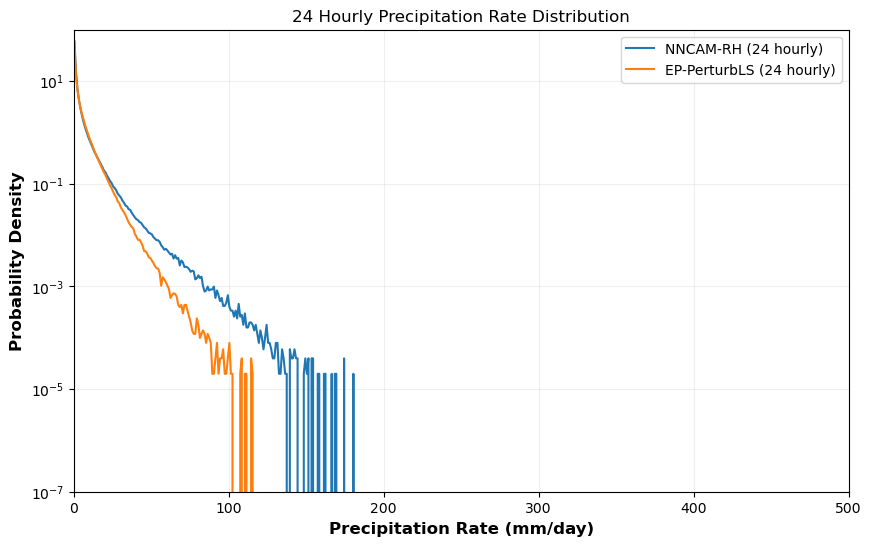

In [93]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.resample('24h').mean()
ep_hourly = ep_df.resample('24h').mean()

# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()

# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)

plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (24 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (24 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('24 Hourly Precipitation Rate Distribution')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()